In [161]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps
from scipy import stats
import math 
import statistics 
from scipy.integrate import quad
import seaborn as sns
from scipy.stats import chi2, norm
from scipy.optimize import minimize

In [162]:
x = np.array([5,8,6,12,14,18,11,6,13,7])
N = 100


In [164]:
data = np.arange(10)
data = np.vstack((data, [1/(np.max(data)-np.min(data))] * 10))
data = np.vstack((data, x))
data = np.vstack((data, x/N))
data

intervals = np.hstack((np.array(-np.inf), data[0][1:], np.array(np.inf))) - 0.5
print(f'intervals: {intervals}')
data

intervals: [-inf  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  inf]


array([[ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ],
       [ 0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
         0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111],
       [ 5.        ,  8.        ,  6.        , 12.        , 14.        ,
        18.        , 11.        ,  6.        , 13.        ,  7.        ],
       [ 0.05      ,  0.08      ,  0.06      ,  0.12      ,  0.14      ,
         0.18      ,  0.11      ,  0.06      ,  0.13      ,  0.07      ]])

In [76]:
x_arr = np.concatenate(np.array([[int(event)] * int(data[2][i]) for i, event in enumerate(data[0])], dtype=object)).astype(int)
x_arr

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9])

# a)

## Пирсон:

In [89]:
delta_est = np.sum((data[2]-N*data[1])**2 / (N*data[1]))
k = 9
print(f'p_value(delta > {np.round(delta_est, 2)} | H_0) = {np.round(chi2(k).sf(delta_est), 3)}')

p_value(delta > 15.87 | H_0) = 0.07


## Колмогоров:

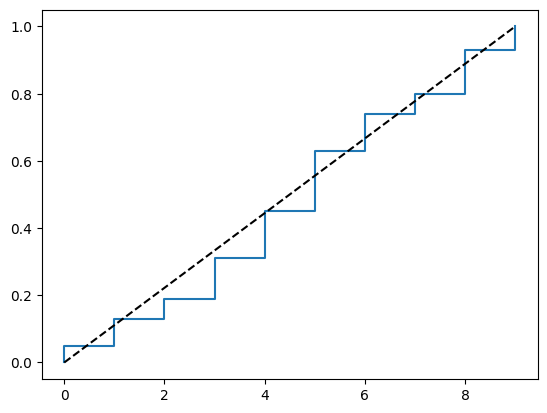

In [125]:
def plot_ecdf(values):
    #строим ЭФР
    X_ = sorted(set(values))
    Y_ = [np.mean(values < x) for x in X_]
    X = sum([[v, v] for v in X_], [])
    Y = sum([[v, v] for v in Y_], [])
    Y = Y[1:]+[1]
    plt.plot(X, Y)
    return Y

Y_ecdf = plot_ecdf(x_arr)

# Строим ФР
X = np.arange(0, 10)
Y = stats.uniform.cdf(X, loc = 0, scale = 9)
plt.plot(X, Y, '--', color='k')

plt.show()

In [126]:
delta_ = max(abs(Y.repeat(2)-Y_ecdf))*N**0.5
delta_ 

1.4333333333333331

In [127]:
p_value = 0
for i in range(1,1000):  
    p_value += -2*(-1**i)*np.exp(-2*i**2*delta_**2)
print(f'p_value(delta > {np.round(delta_, 2)} | H_0) = {np.round(p_value, 3)}')


p_value(delta > 1.43 | H_0) = 0.033


## По Пирсону нет оснований отвергнуть гипотезу, однако по Колмогорову отвергаем

# b)

In [165]:
def fnorm(x, sigma, m):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-m)**2/(2*sigma**2))

In [166]:


def maxes_pla_func(sample_):
    def pla_func(variables):
        mean, sigma = variables
        # считаем сколько элементов выборки попало в интервалы intervals
        counts = [] # количество элементов на каждом интервале из выборки
        for i in range(len(intervals) - 1):
            a, b = intervals[i], intervals[i+1]
            counts = np.append(counts, np.count_nonzero((sample_ < b) & (sample_ >= a)))
        return -np.prod((norm(mean, sigma).cdf(intervals[1:]) - norm(mean, sigma).cdf(intervals[:-1])) ** counts) # минус так как нам нужен минимум
    
    
    interv = [5.0, 3.0]
    result = minimize(pla_func, interv, method='Nelder-Mead')
    return np.round(result.x, 3)


In [167]:
m_, sigma_ = maxes_pla_func(x_arr)
print(sigma_, m_)        

2.679 4.79


In [168]:
probabilities = np.array([quad(integrand, intervals[i], intervals[i+1], args = (sigma_, m_))[0] for i in range(0, len(intervals)-1)])

In [169]:
probabilities 

array([0.0546504 , 0.05505991, 0.08662158, 0.11874054, 0.14182652,
       0.14760566, 0.13385549, 0.1057684 , 0.07282157, 0.08304992])

In [144]:
delta_b = 0
for i in range(len(x)):
    delta_b += (x[i]-N*probabilities[i])**2/(N*probabilities[i])

In [145]:
print(f'p_value(delta > {np.round(delta_b, 2)} | H_0) = {np.round(chi2(9).sf(delta_b), 3)}')

p_value(delta > 9.8 | H_0) = 0.367


## Колмогоров, парам.бутстрап

In [146]:
arr_f = np.array([])
for i in range(0,10):
    arr_f =  np.append(arr_f, quad(fnorm, -np.inf, i, args = (sigma_, m_))[0])

In [147]:
delta_b_kol = max(abs(arr_f.repeat(2) - Y_ecdf))*np.sqrt(N)
print(f"basic delta in Kolmogorov = {delta_b_kol}")

basic delta in Kolmogorov = 0.9875992494644592


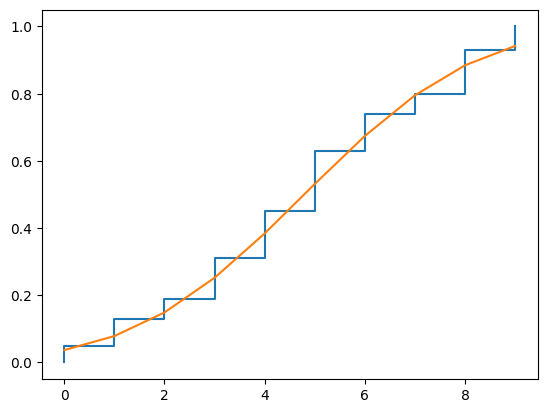

In [148]:
plot_ecdf(x_arr)
plt.plot(np.arange(0,10), arr_f)
plt.show() 

In [149]:
%%time
delta_arr = np.array([])
btN = 20000
for i in range(0, btN):
    if not i%500:
        print(i)
    bootstrap = np.sort(np.random.normal(m_, sigma_, N).astype(int))
    count = np.array([])
    for i in [0,1,2,3,4,5,6,7,8,9]:
        count = np.append(count, sum(bootstrap == i)) 
    m_i, sigma_i = maxes_pla_func(count)
    arr_f = np.array([])
    for j in range(0,10):
        arr_f =  np.append(arr_f, quad(fnorm, -np.inf, j, args = (sigma_i, m_i))[0])
    delta_arr = np.append(delta_arr, max(abs(arr_f.repeat(2) - Y_ecdf))*np.sqrt(N))

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
CPU times: total: 18min 57s
Wall time: 43min 41s


In [154]:
delta_arr.sort()  


In [157]:
p_value_b_kol = sum(delta_arr >= delta_b_kol) / btN

In [158]:
print(f"p_value by Kolmogorov and parametric_bootstrap = {p_value_b_kol}")

p_value by Kolmogorov and parametric_bootstrap = 1.0


## Нет оснований отвергнуть основную гипотезу